In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

# import required libraries for clustering
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

# for interactive visualizations
import plotly.offline as py
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
from plotly import tools
init_notebook_mode(connected = True)
import plotly.figure_factory as ff

In [4]:
#Loading data set
url='https://raw.githubusercontent.com/satarupa5/online-retail-data-analysis/master/original-dataset/Online_Retail.csv'

data = pd.read_csv(url, sep=",", encoding="ISO-8859-1", header=0)
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [6]:
#Sanity check
data.shape

(541909, 8)

In [7]:
data.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null object
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [9]:
#Data Cleaning

In [14]:

#Na Handling
data.isnull().values.any()
data.isnull().values.sum()


136534

In [15]:
#dropping na cells
retaildata=data.dropna()

In [16]:
#sanity check
retaildata.shape



(406829, 8)

In [17]:
retaildata.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

#Data Preparation:

    We are going to analysis the Customers based on below 3 factors:
    R (Recency): Number of days since last purchase
    F (Frequency): Number of tracsactions
    M (Monetary): Total amount of transactions (revenue contributed)

In [20]:
#Creating monetary attribute

retaildata['Amount']=retaildata['Quantity']*retaildata['UnitPrice']
rfm_monetary=retaildata.groupby('CustomerID')['Amount'].sum()
rfm_monetary=rfm_monetary.reset_index()
rfm_monetary.head()

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,CustomerID,Amount
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [21]:
#Creating new attribute Frequency

rfm_frequency=retaildata.groupby('CustomerID')['InvoiceNo'].count()
rfm_frequency=rfm_frequency.reset_index()
rfm_frequency.columns=['CustomerID','Frequency']
rfm_frequency.head()

,CustomerID,Frequency
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [23]:
#Merging Frequency and Monetary data frame
rfm=pd.merge(rfm_monetary,rfm_frequency,on='CustomerID',how='inner')
rfm.head()

,CustomerID,Amount,Frequency
0,12346.0,0.00,2
1,12347.0,4310.00,182
2,12348.0,1797.24,31
3,12349.0,1757.55,73
4,12350.0,334.40,17


In [30]:
#Generating receny function
 
# Convert to datetime to proper datatype

retaildata['InvoiceDate'] = pd.to_datetime(retaildata['InvoiceDate'],format='%d-%m-%Y %H:%M')

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [32]:
# Compute the maximum date to know the last transaction date

max_date = max(retaildata['InvoiceDate'])
max_date

Timestamp('2011-12-09 12:50:00')

In [34]:
retaildata['Diff']=max_date-retaildata['InvoiceDate']
retaildata.head()

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount,Diff
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,373 days 04:24:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,373 days 04:24:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00


In [35]:
# Compute last transaction date to get the recency of customers

rfm_p = retaildata.groupby('CustomerID')['Diff'].min()
rfm_p = rfm_p.reset_index()
rfm_p.head()

,CustomerID,Diff
0,12346.0,325 days 02:33:00
1,12347.0,1 days 20:58:00
2,12348.0,74 days 23:37:00
3,12349.0,18 days 02:59:00
4,12350.0,309 days 20:49:00


In [36]:
# Extract number of days only

rfm_p['Diff'] = rfm_p['Diff'].dt.days
rfm_p.head()

,CustomerID,Diff
0,12346.0,325
1,12347.0,1
2,12348.0,74
3,12349.0,18
4,12350.0,309


In [37]:
# Merge tha dataframes to get the final RFM dataframe

rfm = pd.merge(rfm, rfm_p, on='CustomerID', how='inner')
rfm.columns = ['CustomerID', 'Amount', 'Frequency', 'Recency']
rfm.head()

,CustomerID,Amount,Frequency,Recency
0,12346.0,0.00,2,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


#Outlier Treatment

    There are 2 types of outliers and we will treat outliers as it can skew our dataset
    Statistical
    Domain specific

Text(0.5, 0, 'Attributes')

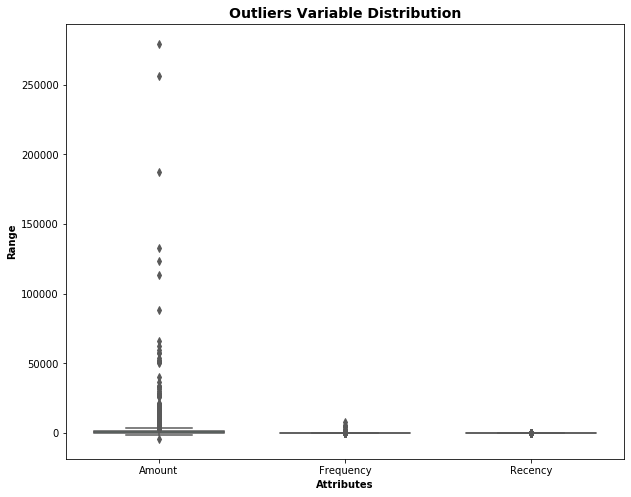

In [39]:
# Outlier Analysis of Amount Frequency and Recency

attributes = ['Amount','Frequency','Recency']
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = rfm[attributes], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')

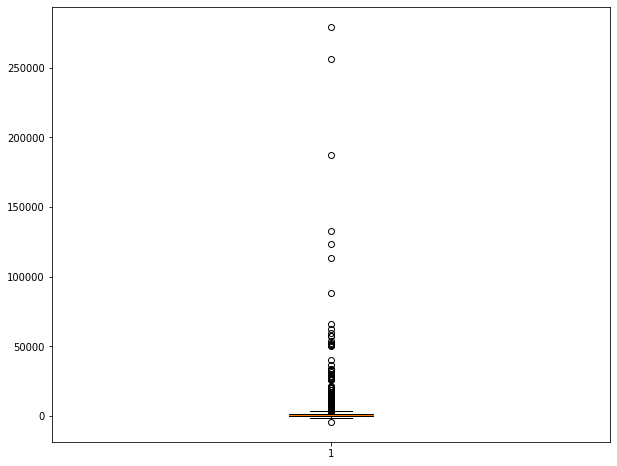

In [42]:
# outlier treatment for Amount
plt.boxplot(rfm.Amount)
Q1 = rfm.Amount.quantile(0.25)
Q3 = rfm.Amount.quantile(0.75)
IQR = Q3 - Q1
rfm = rfm[(rfm.Amount >= Q1 - 1.5*IQR) & (rfm.Amount <= Q3 + 1.5*IQR)]

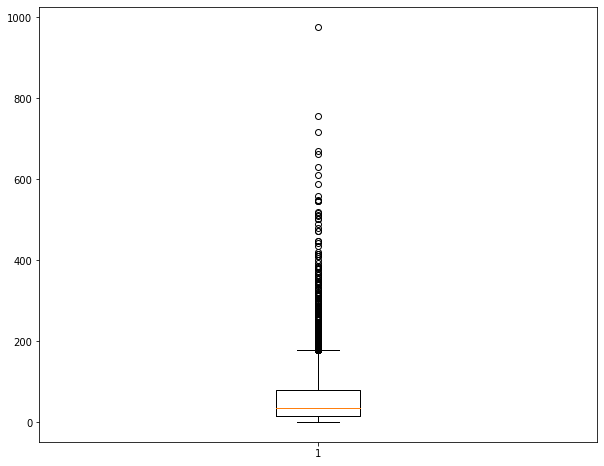

In [43]:
# outlier treatment for Frequency
plt.boxplot(rfm.Frequency)
Q1 = rfm.Frequency.quantile(0.25)
Q3 = rfm.Frequency.quantile(0.75)
IQR = Q3 - Q1
rfm = rfm[(rfm.Frequency >= Q1 - 1.5*IQR) & (rfm.Frequency <= Q3 + 1.5*IQR)]

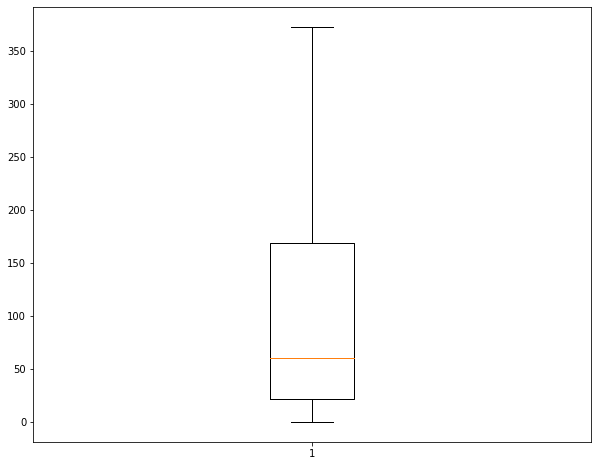

In [45]:

# outlier treatment for Recency
plt.boxplot(rfm.Recency)
Q1 = rfm.Recency.quantile(0.25)
Q3 = rfm.Recency.quantile(0.75)
IQR = Q3 - Q1
rfm = rfm[(rfm.Recency >= Q1 - 1.5*IQR) & (rfm.Recency <= Q3 + 1.5*IQR)]

In [46]:

rfm.head(20)

,CustomerID,Amount,Frequency,Recency
0,12346.0,0.00,2,325
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309
5,12352.0,1545.41,95,35
6,12353.0,89.00,4,203
7,12354.0,1079.40,58,231
8,12355.0,459.40,13,213
9,12356.0,2811.43,59,22
11,12358.0,1168.06,19,1


Rescaling the Attributes:
                        
    It is extremely important to rescale the variables so that they have a comparable scale.| There are two common ways of rescaling:
    Min-Max scaling 
    Standardisation (mean-0, sigma-1)
          Here, we will use Standardisation Scaling.

In [47]:
# Rescaling the attributes

rfm_df = rfm[['Amount', 'Frequency', 'Recency']]

# Instantiate
scaler = StandardScaler()

# fit_transform
rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled.shape

(3697, 3)

In [48]:
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['Amount', 'Frequency', 'Recency']
rfm_df_scaled.head()

,Amount,Frequency,Recency
0,-1.041614,-1.070949,2.136422
1,1.385298,-0.375498,-0.282050
2,1.331702,0.631707,-0.821629
3,-0.590055,-0.711233,1.982257
4,1.045238,1.159290,-0.657828


In [49]:
#Building the model

In [50]:
#Kmeans clustering

In [51]:
# k-means with some arbitrary k

kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [52]:
kmeans.labels_

array([0, 3, 3, ..., 0, 1, 3])

#Elbow curve to find the optimal parameter

     Elbow Curve to get the right number of Clusters:
     A fundamental step for any unsupervised algorithm is to determine the optimal number of clusters into which the data may be clustered. The Elbow Method is one of the most popular methods to determine this optimal value of k.

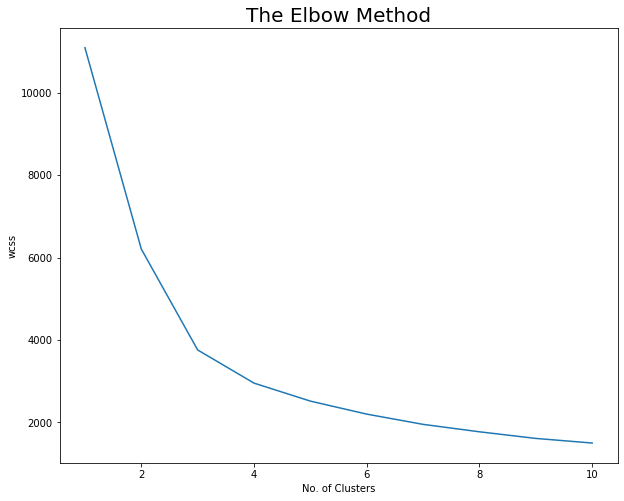

In [57]:
#Elbow method to find number of optimal clusters

# Elbow-curve/SSD

ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    ssd.append(kmeans.inertia_)
    
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method', fontsize = 20)
plt.xlabel('No. of Clusters')
plt.ylabel('wcss')
plt.show()

#Silhoutte Analysis:
         
    Silhouette Analysis
    silhouette score=(p−q)/max(p,q)
 
    p  is the mean distance to the points in the nearest cluster that the data point is not a part of

    q  is the mean intra-cluster distance to all the points in its own cluster.

    The value of the silhouette score range lies between -1 to 1.

    A score closer to 1 indicates that the data point is very similar to other data points in the cluster,

    A score closer to -1 indicates that the data point is not similar to the data points in its cluster

In [56]:
# Silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(rfm_df_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))
    
    

For n_clusters=2, the silhouette score is 0.42929467976639346
For n_clusters=3, the silhouette score is 0.4394022657809714
For n_clusters=4, the silhouette score is 0.40851721359807264
For n_clusters=5, the silhouette score is 0.38940731623509356
For n_clusters=6, the silhouette score is 0.3553936594103036
For n_clusters=7, the silhouette score is 0.33227385778667895
For n_clusters=8, the silhouette score is 0.3411560444456715


In [58]:
# Final model with k=3
kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [59]:
 kmeans.labels_

array([2, 0, 1, ..., 2, 0, 1])

In [60]:
# assign the label
rfm['Cluster_Id'] = kmeans.labels_
rfm.head()

,CustomerID,Amount,Frequency,Recency,Cluster_Id
0,12346.0,0.00,2,325,2
2,12348.0,1797.24,31,74,0
3,12349.0,1757.55,73,18,1
4,12350.0,334.40,17,309,2
5,12352.0,1545.41,95,35,1


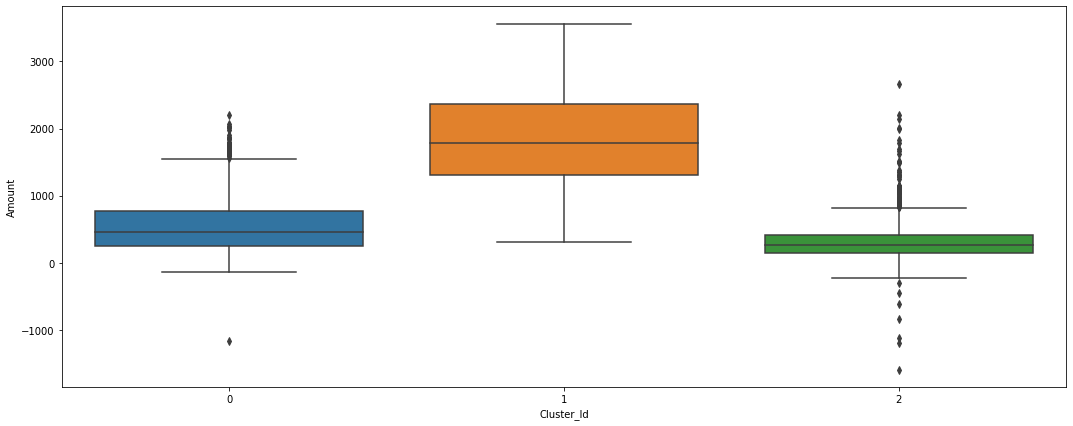

In [64]:

# Box plot to visualize Cluster Id vs Frequency

sns.boxplot(x='Cluster_Id', y='Amount', data=rfm)

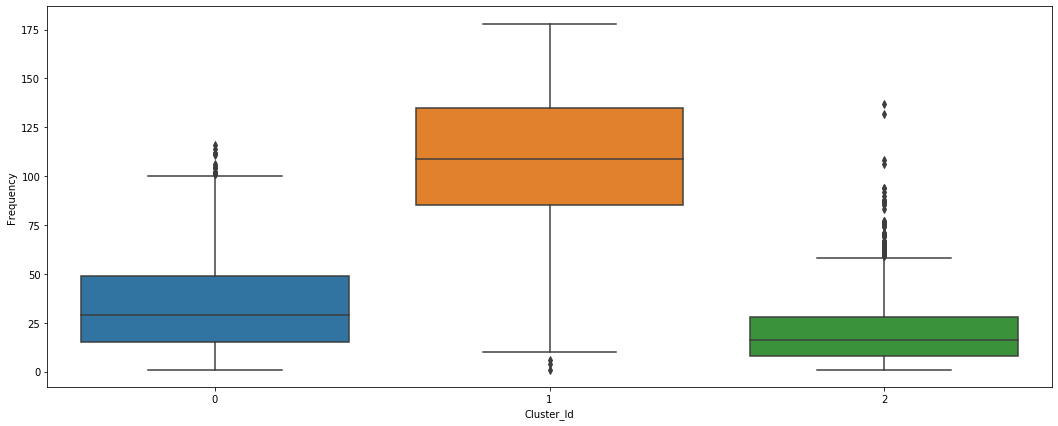

In [63]:
# Box plot to visualize Cluster Id vs Frequency

sns.boxplot(x='Cluster_Id', y='Frequency', data=rfm)

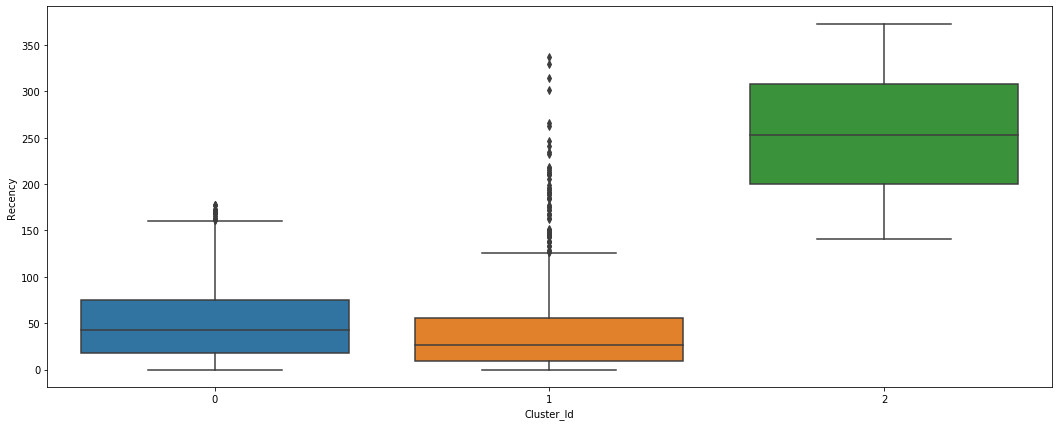

In [65]:
# Box plot to visualize Cluster Id vs Recency

sns.boxplot(x='Cluster_Id', y='Recency', data=rfm)

Hierarchical Clustering:
            
            
    Hierarchical clustering involves creating clusters that have a predetermined ordering from top to bottom. For example, all files and folders on the hard disk are organized in a hierarchy. There are two types of hierarchical clustering,


    Divisive
    Agglomerative.
    
    Single Linkage:

    In single linkage hierarchical clustering, the distance between two clusters is defined as the shortest distance between two points in each cluster. 

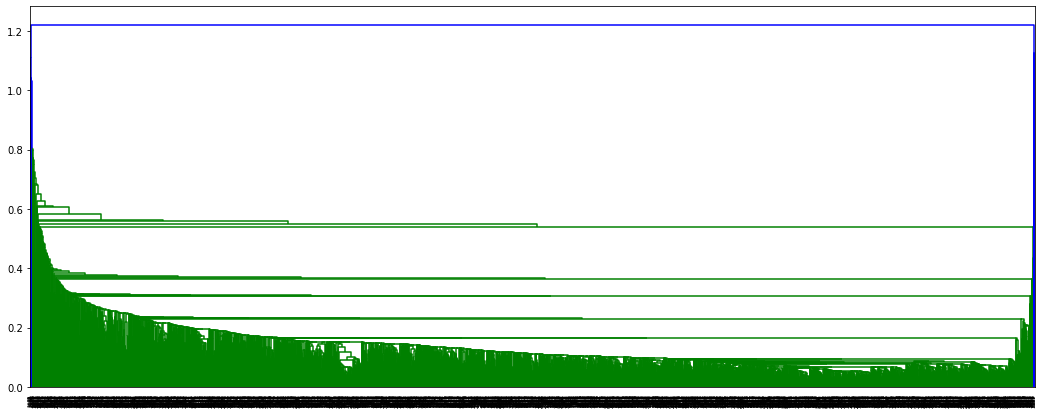

In [66]:
# Single linkage: 

mergings = linkage(rfm_df_scaled, method="single", metric='euclidean')
dendrogram(mergings)
plt.show()

Complete Linkage:

    In complete linkage hierarchical clustering, the distance between two clusters is defined as the longest distance between two points in each cluster. 

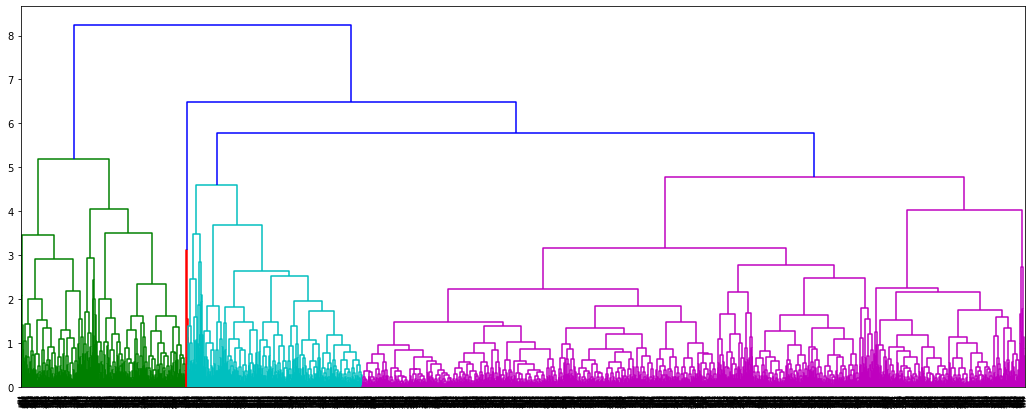

In [67]:
# Complete linkage

mergings = linkage(rfm_df_scaled, method="complete", metric='euclidean')
dendrogram(mergings)
plt.show()

Average Linkage:

    In average linkage hierarchical clustering, the distance between two clusters is defined as the average distance between each point in one cluster to every point in the other cluster

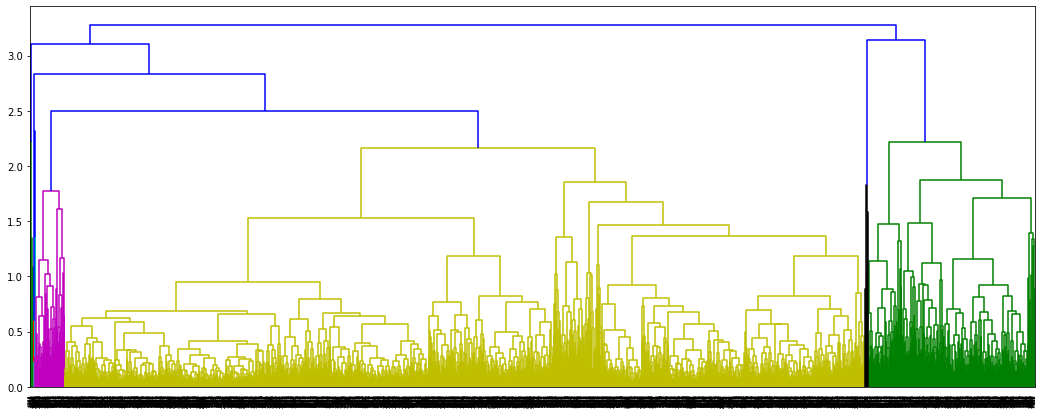

In [68]:
# Average linkage

mergings = linkage(rfm_df_scaled, method="average", metric='euclidean')
dendrogram(mergings)
plt.show()

In [69]:
#cutting dendogram based on K value

In [70]:
# 3 clusters
cluster_labels = cut_tree(mergings, n_clusters=3).reshape(-1, )
cluster_labels

array([0, 0, 1, ..., 0, 0, 1])

In [71]:
# Assign cluster labels

rfm['Cluster_Labels'] = cluster_labels
rfm.head()

,CustomerID,Amount,Frequency,Recency,Cluster_Id,Cluster_Labels
0,12346.0,0.00,2,325,2,0
2,12348.0,1797.24,31,74,0,0
3,12349.0,1757.55,73,18,1,1
4,12350.0,334.40,17,309,2,0
5,12352.0,1545.41,95,35,1,1


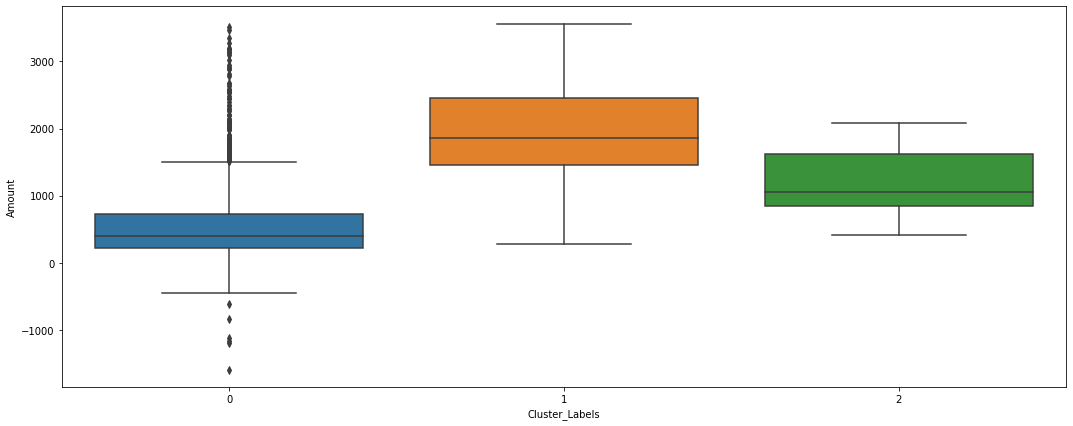

In [72]:
# Plot Cluster Id vs Amount

sns.boxplot(x='Cluster_Labels', y='Amount', data=rfm)

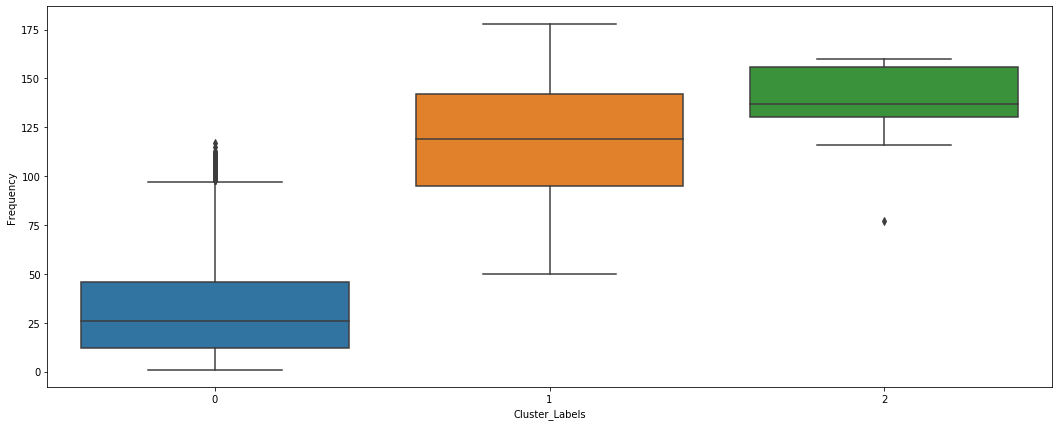

In [73]:
# Plot Cluster Id vs Frequency

sns.boxplot(x='Cluster_Labels', y='Frequency', data=rfm)

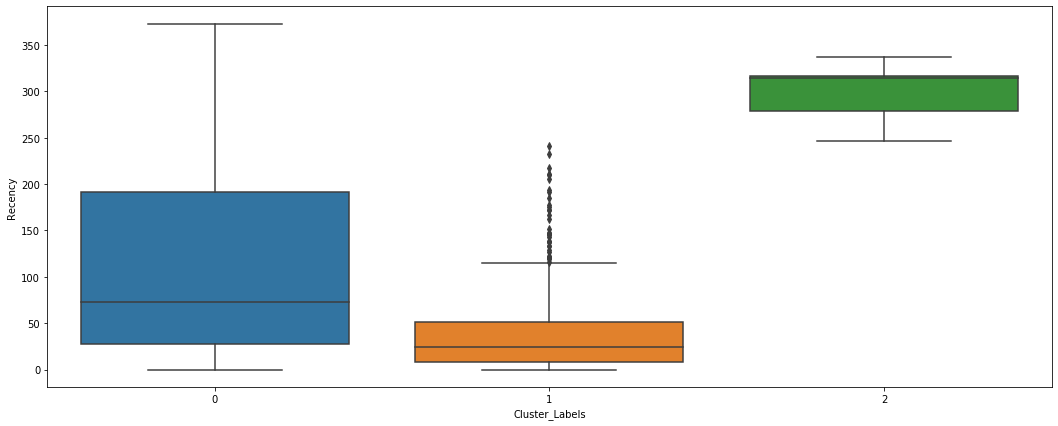

In [74]:
# Plot Cluster Id vs Recency

sns.boxplot(x='Cluster_Labels', y='Recency', data=rfm)

Inference:

    K-Means Clustering with 3 Cluster Ids:

    Customers with Cluster Id 1 are the customers with high amount of transactions as compared to other customers.
    Customers with Cluster Id 1 are frequent buyers.
    Customers with Cluster Id 2 are not recent buyers and hence least of importance from business point of view.
    
    Hierarchical Clustering with 3 Cluster Labels:

    Customers with Cluster_Labels 2 are the customers with high amount of transactions as compared to other customers.
    Customers with Cluster_Labels 2 are frequent buyers.
    Customers with Cluster_Labels 0 are not recent buyers and hence least of importance from business point of view.